In [19]:
# import os
# import numpy as np
# import pandas as pd
# import scipy.sparse as sp
# import scanpy as sc

# # Function to create a single dummy AnnData object
# def create_dummy_adata(row_name, var_names, n_columns=100, sparsity=0.9):
#     # Create a sparse matrix mostly containing 0s
#     data = sp.csr_matrix(np.random.binomial(1, 1 - sparsity, (1, n_columns)))
    
#     # Create the AnnData object
#     adata = sc.AnnData(data, var=pd.DataFrame(index=var_names))
#     adata.obs_names = [row_name]  # Set row (observation) name
    
#     return adata


# tissue_list = ["brain", "lung", "brain", "liver", "spleen", "liver", "brain", "stomach", "neck", "prostate"]

# # Generate 5 dummy AnnData objects
# n_columns=100
# var_names = [f"seq_{np.random.randint(1000000, 9999999)}" for _ in range(n_columns)]
# dummy_adata_list = [create_dummy_adata(f"sample_{i+1}", var_names=var_names, n_columns=n_columns) for i in range(len(tissue_list))]

# # Sample data to simulate `adata.var_names` (list of sequence identifiers)
# seq_ids = dummy_adata_list[0].var_names  # Replace with actual `adata.var_names` from the AnnData object

# # Generate the DataFrame with the specified columns
# mutation_metadata_df = pd.DataFrame({
#     'mcrs_id': seq_ids,
#     'gene_name': [f"gene_{i}" for i in range(len(seq_ids))],  # Generate gene names as placeholders
# })

# # Add the `header_with_gene_name` column by combining `gene_name` and `mcrs_id`
# mutation_metadata_df['header_with_gene_name'] = mutation_metadata_df['gene_name'] + "_" + mutation_metadata_df['mcrs_id']

# number_of_cancer_types=7
# use_binary_matrix = False
# tolerance=3  # tolerance in diff between number of leiden clusters and number of cancer types
# n_comps = 7  # number of PCs
# minimum_count_filter = 2  # anything below this will be set to 0
# k = 10  # number of nearest neighbors for knn with unknown sample

# base_dir = "/home/jrich/data/varseek_data/sequencing/bulk/ccle_test"
# os.makedirs(base_dir, exist_ok=True)

# for i in range(len(dummy_adata_list)):
#     study = f"RNAseq__123_{tissue_list[i]}___sample{i}___experiment{i}___run{i}"
#     out_dir = os.path.join(base_dir, "kb_count_out", study, "kb_count_out_mutation_index", "counts_unfiltered")
#     os.makedirs(out_dir, exist_ok=True)
#     dummy_adata_list[i].write(os.path.join(out_dir, "adata.h5ad"))

# n_columns=10000
# var_names = [f"seq_{np.random.randint(1000000, 9999999)}" for _ in range(n_columns)]
# dummy_adata_list_normal = [create_dummy_adata(f"sample_{i+1}", var_names=var_names, n_columns=n_columns) for i in range(len(tissue_list))]

# for i in range(len(dummy_adata_list)):
#     study = f"RNAseq__123_{tissue_list[i]}___sample{i}___experiment{i}___run{i}"
#     out_dir = os.path.join(base_dir, "kb_count_out", study, "kb_count_out_standard_index", "counts_unfiltered")
#     os.makedirs(out_dir, exist_ok=True)
#     dummy_adata_list[i].write(os.path.join(out_dir, "adata.h5ad"))

In [2]:
import os
import varseek as vk
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.metrics import adjusted_rand_score
from anndata import concat

from varseek.utils import plot_items_descending_order, plot_scree, plot_loading_contributions, find_resolution_for_target_clusters, plot_contingency_table, plot_knn_tissue_frequencies, plot_ascending_bar_plot_of_cluster_distances, plot_jaccard_bar_plot
number_of_cancer_types = 15  #!!! change to 38

def get_tissue_name_from_experiment_alias(experiment_alias_underscores_only):
    experiment_alias_underscores_only_without_rnaseq_list = experiment_alias_underscores_only.split("__")
    experiment_alias_underscores_only_without_rnaseq_string = "_".join(experiment_alias_underscores_only_without_rnaseq_list[1:])
    tissue_list = experiment_alias_underscores_only_without_rnaseq_string.split("_")[1:]
    tissue_string = "_".join(tissue_list)
    return tissue_string

CCLE has 38 cancer types and 1019 cell lines

In [5]:
minimum_count_filter = 2  # anything below this will be set to 0
use_binary_matrix = False
do_cpm_normalization = False
tolerance=3  # tolerance in diff between number of leiden clusters and number of cancer types
n_comps = 50  # number of PCs
matrix_type = "mutation"  # mutation or gene

mutation_metadata_df_path = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/mutation_metadata_df_filtered.csv"
mutation_metadata_df_columns = ["mcrs_id", "gene_name", "header_with_gene_name"]  #* change usecols as desired
base_dir = "/home/jrich/data/varseek_data/sequencing/bulk/ccle"
ccle_data_out_dir = os.path.join(base_dir, "ccle_data_out_medium")  #!!! change to ccle_data_out

In [6]:
mutation_metadata_df = pd.read_csv(mutation_metadata_df_path, index_col=0, usecols = mutation_metadata_df_columns)

1. Load in matrix after preprocessing
2. Combine each cancer type row into one matrix
3. re-plot the top n mutations for each cancer type in descending line plots with expression as y axis (or even just lists)
4. Run PCA on the combined matrix - make PCA plot, Scree plot, loadings plot (which mutations contributed to the major PCs)
5. Plot heatmap of mutation expression (or some other value) for each mutation (x) and sample i.e., cancer type (y) eg seaborn

In [7]:
adata_list = []
for study in os.listdir(ccle_data_out_dir):
    full_path = os.path.join(ccle_data_out_dir, study)
    experiment_alias_underscores_only, sample_accession, experiment_accession, run_accession = study.split("___")
    tissue = get_tissue_name_from_experiment_alias(experiment_alias_underscores_only)
    kb_count_out_mutation_index_dir = os.path.join(full_path, "kb_count_out_mutation_index")
    kb_count_out_standard_index_dir = os.path.join(full_path, "kb_count_out_standard_index")

    adata_mutation_path = f"{kb_count_out_mutation_index_dir}/counts_unfiltered/adata.h5ad"

    adata_mutation = sc.read_h5ad(adata_mutation_path)
    adata_mutation.obs_names = [f"{experiment_accession}_{tissue}"]

    adata_mutation.obs["sample_accession"] = sample_accession
    adata_mutation.obs["experiment_accession"] = experiment_accession
    adata_mutation.obs["run_accession"] = run_accession
    adata_mutation.obs["experiment_alias_underscores_only"] = experiment_alias_underscores_only
    adata_mutation.obs["tissue"] = tissue

    # TODO: change split_reads_by_Ns to True once I fix this function in vk clean
    adata_mutation = vk.clean(adata_mutation, minimum_count_filter = minimum_count_filter, use_binary_matrix = use_binary_matrix, assay = "bulk", do_cpm_normalization = do_cpm_normalization, split_reads_by_Ns = False)
    if 'mcrs_count' in adata_mutation.var.columns:
        adata_mutation.var.drop('mcrs_count', axis=1, inplace=True)

    adata_list.append(adata_mutation)

adata = concat(adata_list, join='outer')

if use_binary_matrix:
    adata.X = (adata.X > 0).astype(int)

adata.var['mcrs_id'] = adata.var.index
original_var_names = adata.var_names.copy()
# merge adata.var with mutation_metadata_df by mcrs_id
adata.var = adata.var.merge(mutation_metadata_df, on='mcrs_id', how='left')
adata.var_names = original_var_names


# print(type(adata.X))  # Should be a sparse matrix type if stored that way in the originals
# print(adata.X.shape)   # Should show (1019, 5.3M)
# print(adata.obs.head())
# print(adata.var.head())
print(adata.shape)

UnboundLocalError: local variable 'adata_normal_genome' referenced before assignment

In [ ]:
if matrix_type == "gene":
    # Step 1: Extract mutation-gene mappings
    gene_mapping = adata.var['gene_name']

    # Step 2: Convert your data to a DataFrame for easier manipulation
    # `X` is typically the main data matrix in `adata`, which we assume is sparse
    data_df = pd.DataFrame.sparse.from_spmatrix(adata.X, index=adata.obs_names, columns=adata.var_names)

    # Step 3: Add gene mapping to the DataFrame for aggregation
    data_df.columns = gene_mapping.values

    # Step 4: Group by gene and sum across mutations belonging to the same gene
    data_gene_df = data_df.groupby(axis=1, level=0).sum()

    # Step 5: Convert the result back into an AnnData object
    adata_gene = sc.AnnData(data_gene_df)
    adata_gene.obs_names = adata.obs_names  # Copy sample names
    adata_gene.var_names = data_gene_df.columns  # Gene names
    adata = adata_gene.copy()

## Drop 0 columns

In [101]:
# Identify columns (genes) with non-zero counts across samples
nonzero_gene_mask = np.array((adata.X != 0).sum(axis=0)).flatten() > 0

# Filter the AnnData object to keep only genes with non-zero counts across samples
adata = adata[:, nonzero_gene_mask]

# Check the new shape to confirm columns were removed
print(adata.shape)  # Should be (1019, <=5.3M)

(5, 33)


## Perform PCA

In [ ]:
# Log-transform the data
sc.pp.log1p(adata)

# Scale the data
sc.pp.scale(adata)

# Run PCA, specifying the number of components
sc.tl.pca(adata, n_comps=n_comps)

# Sample scores on the first few principal components
print(adata.obsm["X_pca"])

# Explained variance for each component
print(adata.uns["pca"]["variance_ratio"])

# plot PCA
pca_plot_dir = f"{base_dir}/pca_plot"
os.makedirs(pca_plot_dir, exist_ok=True)
pca_fig = sc.pl.pca(adata)
pca_fig.savefig(f"{pca_plot_dir}/pca.png", dpi=300)
plot_scree(adata, output_plot_file=f"{pca_plot_dir}/scree.png")  # scree plot   # sc.pl.pca_variance_ratio(adata, n_pcs=n_comps, log=True)

for pc_index in range(n_comps):
    pca_plot_dir_pc_specific = f"{pca_plot_dir}/loading_{pc_index}"
    os.makedirs(pca_plot_dir_pc_specific, exist_ok=True)
    plot_loading_contributions(adata, PC_index = pc_index, top_genes_stats = 100, top_genes_plot = 10, output_stats_file = f"{pca_plot_dir_pc_specific}/top_genes_stats.txt", output_plot_file=f"{pca_plot_dir_pc_specific}/loadings.png")

# knn, clustering, alluvial
sc.pp.neighbors(adata, n_neighbors=15)

adata, resolution, num_clusters = find_resolution_for_target_clusters(adata, target_clusters=number_of_cancer_types, tolerance=tolerance)
print(f"Optimal resolution for ~{number_of_cancer_types} clusters: {resolution} (yielded {num_clusters} clusters)")

In [ ]:
pca_fig = sc.pl.pca(adata, color='tissue', title="PCA colored by tissue", save="tissue.png")
pca_fig.savefig(f"{pca_plot_dir}/pca_tissue.png", dpi=300)
pca_fig = sc.pl.pca(adata, color='leiden', title="PCA colored by Leiden clusters", save="leiden.png")
pca_fig.savefig(f"{pca_plot_dir}/pca_leiden.png", dpi=300)

In [109]:
adata.uns['tissue_leiden_ari'] = adjusted_rand_score(adata.obs['tissue'], adata.obs['leiden'])
print(f"Adjusted Rand Index (ARI) between 'leiden' and 'tissue': {adata.uns['tissue_leiden_ari']}")

Adjusted Rand Index (ARI) between 'leiden' and 'tissue': 0.0


In [ ]:
# neighbornet - see Tara's paper - https://github.com/pachterlab/CP_2021

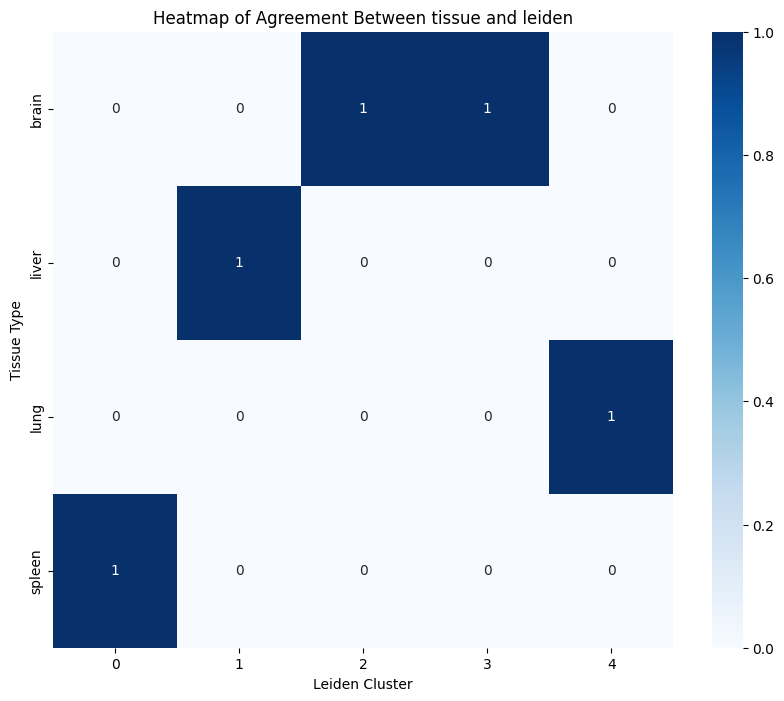

In [110]:
plot_contingency_table(adata, column1 = "tissue", column2 = "leiden", output_plot_file=f"{base_dir}/contingency_table.png")  #* consider replacing with my alluvial plot

In [ ]:
grouped_tissue_dir = f"{base_dir}/grouped_tissue"

# Iterate through each unique tissue type
for tissue in adata.obs['tissue'].unique():
    specific_tissue_dir = f"{grouped_tissue_dir}/{tissue}"
    os.makedirs(specific_tissue_dir, exist_ok=True)

    # Subset adata for the current tissue
    tissue_adata_temp = adata[adata.obs['tissue'] == tissue].copy()
    
    # Sum the matrix across rows (cells) for this tissue, resulting in a 1-row array
    summed_matrix = tissue_adata_temp.X.sum(axis=0)  # Sum across rows for each column

    if not sp.issparse(summed_matrix):
        summed_matrix = sp.csr_matrix(summed_matrix)  # Convert to sparse if not already

    if type(summed_matrix) == np.ndarray:
        summed_matrix = summed_matrix.reshape(1, -1)

    # Create a new adata object with a single row containing the summed values
    adata_tissue_specific = sc.AnnData(summed_matrix, var=tissue_adata_temp.var)
    
    # Update the 'obs' for this single-row adata to reflect the tissue type
    adata_tissue_specific.obs['tissue'] = [tissue]

    if hasattr(adata_tissue_specific.X, "A1"):
        transcript_counts = adata_tissue_specific.X.sum(axis=0).A1  # Sparse to dense array
    else:
        transcript_counts = np.array(adata_tissue_specific.X.sum(axis=0)).flatten()  # Already dense, no need for .A1

    # Add this as a new column to adata.var
    adata_tissue_specific.var['transcript_count'] = transcript_counts

    adata_tissue_specific.var = adata_tissue_specific.var.sort_values(by='transcript_count', ascending=False)

    sorted_mutations_file = f"{specific_tissue_dir}/sorted_mutations.txt"
    with open(sorted_mutations_file, "w") as f:
        for mutation_name, transcript_count in zip(adata_tissue_specific.var['header_with_gene_name'], adata_tissue_specific.var['transcript_count']):
            f.write(f"{mutation_name} {transcript_count}\n")

    plot_items_descending_order(adata_tissue_specific.var, x_column = 'header_with_gene_name', y_column = 'transcript_count', item_range = (0,100), xlabel = "Mutation", title = "Top 100 Mutations by Transcript Count", save_path = f'{specific_tissue_dir}/top_100_mutations_plot.png', figsize = (15, 7))
    plot_items_descending_order(adata_tissue_specific.var, x_column = 'header_with_gene_name', y_column = 'transcript_count', item_range = (0,1000), xlabel = "Mutation Index", title = "Top 1000 Mutations by Transcript Count", save_path = f'{specific_tissue_dir}/top_1000_mutations_plot.png', figsize = (15, 7))

    combined_gene = adata_tissue_specific.var.groupby('gene_name', as_index=False)['transcript_count'].sum()
    combined_gene = pd.merge(combined_gene, adata_tissue_specific.var[['gene_name']], on='gene_name', how='left')
    combined_gene = combined_gene.drop_duplicates(subset='gene_name', keep='first')
    adata_tissue_specific.uns['combined_genes'] = combined_gene.sort_values(by='transcript_count', ascending=False)

    sorted_mutated_genes_file = f"{specific_tissue_dir}/sorted_mutated_genes.txt"
    with open(sorted_mutated_genes_file, "w") as f:
        for gene_name, transcript_count in zip(adata_tissue_specific.uns['combined_genes']['gene_name'], adata_tissue_specific.uns['combined_genes']['transcript_count']):
            f.write(f"{gene_name} {transcript_count}\n")

    plot_items_descending_order(adata_tissue_specific.uns['combined_genes'], x_column = 'gene_name', y_column = 'transcript_count', item_range = (0,100), xlabel = "Gene", title = "Top 100 Genes by Transcript Count", save_path = f'{specific_tissue_dir}/top_100_genes_plot.png', figsize = (15, 7))

In [ ]:
adata.write(f"{base_dir}/adata_combined_ccle_rnaseq.h5ad")

In [ ]:
#!! for each cancer type, split into 2/3 1/3 and train a ML model to predict the cancer type
#!! take just variant matrix and try to predict cancer type; and similarly do by normal sample x mutation matrix (and compare to sample x mutation matrix)